Making Peter happy

In [1]:
from glob import glob
import datetime

import numpy as np
from astropy.table import Table
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import spearmanr
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

In [2]:
HR = pd.read_csv('../data/campbell_local.tsv', sep='\t', usecols=['SNID', 'redshift', 'hr', 'err_mu'], index_col='SNID')
HR.rename(columns={'err_mu': 'hr uncert'}, inplace=True)
HR = HR[HR['redshift']<0.2]  
HR = HR[HR['hr']<0.7]
HR.describe()

,redshift,hr uncert,hr
count,103.000000,103.000000,103.000000
mean,0.143292,0.078358,-0.012718
std,0.042126,0.016502,0.168172
min,0.045248,0.056201,-0.424369
25%,0.114303,0.065649,-0.118307
50%,0.154056,0.075748,-0.030987
75%,0.180766,0.085845,0.078726
max,0.198704,0.133972,0.514934


In [3]:
t = Table.read('../data/SDSS_Photometric_SNe_Ia.fits')
salt = t['CID','Z','X1','X1_ERR','COLOR','COLOR_ERR'].to_pandas()
salt.columns = salt.columns.str.lower()
salt.rename(columns={'cid': 'SNID', 'z': 'redshift'}, inplace=True)
salt.set_index('SNID', inplace=True)
salt.describe()

,redshift,x1,x1_err,color,color_err
count,752.000000,752.000000,752.000000,752.000000,752.000000
mean,0.294032,-0.006514,0.765859,-0.013105,0.059070
std,0.103553,1.082517,0.506811,0.100019,0.023878
min,0.037069,-2.952440,0.061210,-0.245912,0.024959
25%,0.220188,-0.776738,0.426394,-0.084207,0.041157
50%,0.294489,0.022410,0.702974,-0.019256,0.055565
75%,0.369411,0.793196,1.011968,0.051200,0.073263
max,0.700345,2.887440,8.048070,0.246569,0.195758


In [4]:
galaxy = pd.read_csv('../resources/kcorrect_stellarmass.csv',  usecols=['GAL', 'redshift', 'stellarmass'], index_col='GAL')
galaxy.rename(columns={'redshift': 'gal redshift', 'stellarmass': 'stellar mass'}, inplace=True)
galaxy.describe()

,gal redshift,stellar mass
count,305.000000,3.050000e+02
mean,0.223845,4.177042e+10
std,0.071923,5.006189e+10
min,0.045363,3.521470e+07
25%,0.175242,8.513790e+09
50%,0.236310,2.342800e+10
75%,0.284038,5.800110e+10
max,0.336325,3.486340e+11


In [5]:
age = pd.read_csv('../resources/ages_campbell.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age.rename(columns={'# sn id': 'SNID'}, inplace=True)
age.set_index('SNID', inplace=True)
age.describe()

,age
count,103.000000
mean,5.221552
std,2.121162
min,1.628953
25%,3.447774
50%,5.071533
75%,6.625620
max,9.740748


In [6]:
data = pd.concat([HR, salt, galaxy, age], axis=1)
data.dropna(inplace=True)
data['stellar mass'] = np.log10(data['stellar mass'])
data.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.143292,0.078358,-0.012718,0.143292,-0.177168,0.268273,0.010006,0.032914,0.143292,10.152806,5.221552
std,0.042126,0.016502,0.168172,0.042126,1.020424,0.127680,0.083329,0.006243,0.042150,0.693578,2.121162
min,0.045248,0.056201,-0.424369,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,7.546724,1.628953
25%,0.114303,0.065649,-0.118307,0.114303,-0.769090,0.176328,-0.041371,0.028793,0.114276,9.764876,3.447774
50%,0.154056,0.075748,-0.030987,0.154056,-0.115550,0.236314,-0.004241,0.030807,0.154034,10.307932,5.071533
75%,0.180766,0.085845,0.078726,0.180766,0.693757,0.354695,0.081210,0.035345,0.180752,10.632817,6.625620
max,0.198704,0.133972,0.514934,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,11.355490,9.740748


Test non-PCA generated parameters

In [7]:
features = ['x1', 'color', 'stellar mass', 'age']
y = data.loc[:, features].values
scaler = StandardScaler()
scaler.fit(y)   # get the needed transformation off of y
y = scaler.transform(y)     # transform y
y.shape

(103, 4)

In [8]:
coefficients = [-0.557, -0.103, -0.535, -0.627]

In [9]:
delta_alpha = 0.06

In [10]:
def to_pc(data):
    """need input to be a Nx4 numpy array
    """
    x, c, m, a = data[:,0], data[:,1], data[:,2], data[:,3]
    return coefficients[0]*x+coefficients[1]*c+coefficients[2]*m+coefficients[3]*a

In [11]:
# pc = to_pc(data[['x1', 'color', 'stellar mass', 'age']].values)
pc = to_pc(y)

In [12]:
spearmanr(pc, data['hr']-delta_alpha*data["x1"])

SpearmanrResult(correlation=0.4679853270658525, pvalue=6.210499059292744e-07)

In [13]:
(m, b), cov = np.polyfit(pc, data['hr']-delta_alpha*data["x1"], 1, full=False, cov=True)
print(m, b)
print(cov)
print(np.sqrt(cov[0,0]), np.sqrt(cov[1,1]))

0.09228249399017087 -0.0020877004602234
[[ 2.77802151e-04 -1.49668484e-19]
 [-1.49668484e-19  2.25060055e-04]]
0.01666739785730652 0.015002001702488277


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


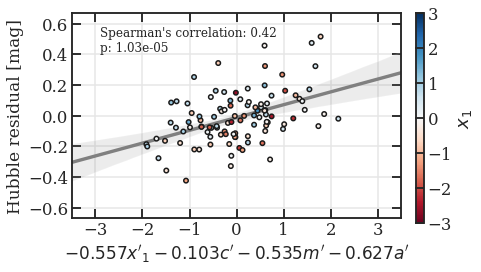

In [29]:
fig = plt.figure()
    
#fix axes major spacing & size
ax = plt.gca()
ax.get_yaxis().set_major_locator(MultipleLocator(0.2))
ax.set_ylim(-0.67, 0.67)
ax.get_xaxis().set_major_locator(MultipleLocator(1))
ax.set_xlim(-3.5, 3.5)

#set axes ticks and gridlines
ax.tick_params(axis='both', top='on', right='on', direction='in')
ax.grid(which='major', axis='both', color='0.90', linestyle='-')
ax.set_axisbelow(True)

sns.regplot(pc, data['hr'], marker='', color='grey', ax=ax)

plt.scatter(pc, data['hr'], marker='.', c=data['x1'],
                cmap="RdBu", vmin=-3.0, vmax=3.0, edgecolor='k', zorder=10)

plt.xlabel(r"$-0.557 x'_1 - 0.103 c' - 0.535 m' - 0.627 a'$", fontsize=17)
plt.ylabel('Hubble residual [mag]', fontsize=17)

cax = fig.add_axes([0.98, 0.197, 0.02, 0.729])
cax.tick_params(axis='y', direction='in')
cax.set_axisbelow(False)   # bring tick marks above coloring
plt.colorbar(label=r"$x_1$", cax=cax)

sp_r, sp_p = spearmanr(pc, data['hr'])
ax.text(-2.9, 0.42, f"Spearman's correlation: {sp_r:.2f}\np: {sp_p:.2e}", 
        {'fontsize':12})

fig.set_tight_layout({'pad': 1.5})
plt.savefig(f'HRvPCalt.pdf', bbox_inches='tight')
plt.show()